In [1]:
import pandas as pd
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from keras.layers import  Dropout
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# First Dataset Was A clear Failure, it doesnt look like stock price but more like Inflation over the past years.
data = pd.read_csv('Datasets/stock_prices.csv')
data.set_index('Date', inplace=True)
data

,Open,High,Low,Close,Volume
Date,,,,,
2018-01-01,214.072839,225.033706,192.951904,209.934283,1671
2018-01-02,311.734725,335.740788,300.734225,307.168997,8927
2018-01-03,410.682114,442.287940,397.182335,420.122768,2171
2018-01-04,531.654671,564.838204,512.134050,550.583365,6591
2018-01-05,654.680687,649.312375,606.114071,645.900297,7342
...,...,...,...,...,...
2023-12-25,158613.180275,159036.923138,146964.288138,157671.179155,8031
2023-12-26,163402.881359,168312.558937,145960.057161,157756.234921,4716
2023-12-27,160441.994607,164282.660837,150457.387200,157807.750116,4414


<Axes: xlabel='Date'>

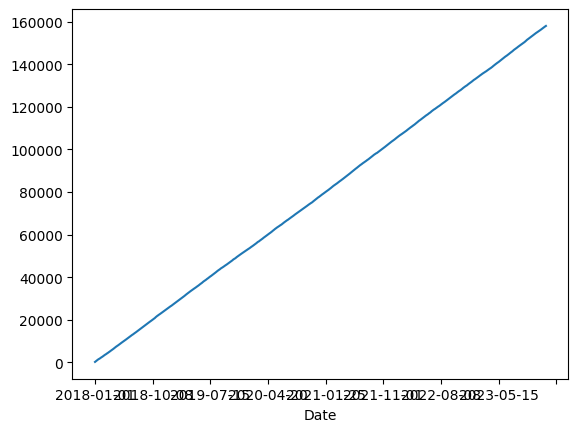

In [2]:
data['Close'].plot()

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Relative Strength Index (RSI)
def compute_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

 

In [4]:
# I asked our Overlord to generate a new Set and it also gave me the code for it GeneratePrices.py
data = pd.read_csv('Datasets/realistic_stock_prices.csv')
data.set_index('Date', inplace=True)
scaler = MinMaxScaler()
data[['Close','Open','High','Volume','Low']] = scaler.fit_transform(data[['Close','Open','High','Volume','Low']])



# Moving Averages (5-day, 20-day)
data['SMA_5'] = data['Close'].rolling(window=5, min_periods=1).mean()
data['SMA_20'] = data['Close'].rolling(window=20, min_periods=1).mean()

# # Daily Returns
# data['Daily_Returns'] = data['Close'].pct_change()



data['RSI'] = compute_rsi(data)
data.dropna(inplace=True)
data

,Open,High,Low,Close,Volume,SMA_5,SMA_20,RSI
Date,,,,,,,,
2018-01-03,0.172572,0.172674,0.174871,0.178980,0.511227,0.175776,0.175776,100.000000
2018-01-04,0.178980,0.190042,0.181039,0.194069,0.162072,0.181874,0.181874,100.000000
2018-01-05,0.194069,0.179686,0.202263,0.191742,0.852268,0.184341,0.184341,90.233209
2018-01-08,0.191742,0.182503,0.183875,0.189417,0.157181,0.185356,0.185356,82.208409
2018-01-09,0.189417,0.202493,0.191108,0.205095,0.863050,0.191861,0.188646,88.877220
...,...,...,...,...,...,...,...,...
2023-12-25,0.935235,0.929861,0.946934,0.934991,0.816252,0.932076,0.927394,60.296894
2023-12-26,0.934991,0.934649,0.932878,0.926459,0.254224,0.931269,0.927992,53.843857
2023-12-27,0.926459,0.910944,0.902882,0.898818,0.819031,0.926767,0.926263,38.056528


In [5]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [6]:
# Define your features and target
features = ['Open','High','Low','Volume','SMA_5', 'SMA_20', 'RSI']
target = 'Close'

# Splitting data: 80% for training, 20% for testing
split = int(0.8 * len(data))

train_data = data[:split]
test_data = data[split:]

X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

In [7]:
# Scale the 'Close' prices between 0 and 1 using MinMaxScaler
scaled_data = scaler.fit_transform(data[['Close']])

# Create sequences for the LSTM model
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # Features
        y.append(data[i + time_step, 0])      # Target
    return np.array(X), np.array(y)

time_step = 60  # Use the last 60 days to predict the next day
X, y = create_sequences(scaled_data, time_step)

# Reshape X to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [8]:
# Build the LSTM model
model2 = Sequential()

# Add the first LSTM layer with Dropout
model2.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model2.add(Dropout(0.2))

# Add the second LSTM layer
model2.add(LSTM(units=50, return_sequences=False))
model2.add(Dropout(0.2))

# Add a Dense output layer
model2.add(Dense(units=1))  # Output is a single value (predicted stock price)

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model2.fit(X_train, y_train, epochs=200, batch_size=64)


Epoch 1/200


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0359
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0044
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014
Epoch 8/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013
Epoch 9/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
Epoch 10/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014
Epoch 11/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013
Epoch 12/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
Epoch 13/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
Epoch 14/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013
Epoch 15/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
E

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


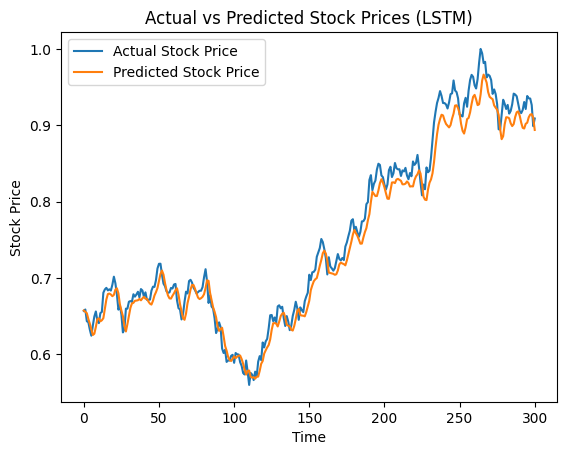

In [9]:
# Predict on the test set
y_pred = model2.predict(X_test)

# Inverse scale the predictions back to the original scale
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.plot(y_test, label='Actual Stock Price')
plt.plot(y_pred, label='Predicted Stock Price')
plt.title('Actual vs Predicted Stock Prices (LSTM)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [10]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.00038961200594600433
Mean Absolute Error: 0.016048059160131176


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1563
Model:                 ARIMA(0, 2, 1)   Log Likelihood                4939.606
Date:                Wed, 02 Oct 2024   AIC                          -9875.212
Time:                        12:45:30   BIC                          -9864.506
Sample:                    01-03-2018   HQIC                         -9871.231
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9985      0.004   -235.307      0.000      -1.007      -0.990
sigma2         0.0001   3.71e-06     28.019      0.000    9.67e-05       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

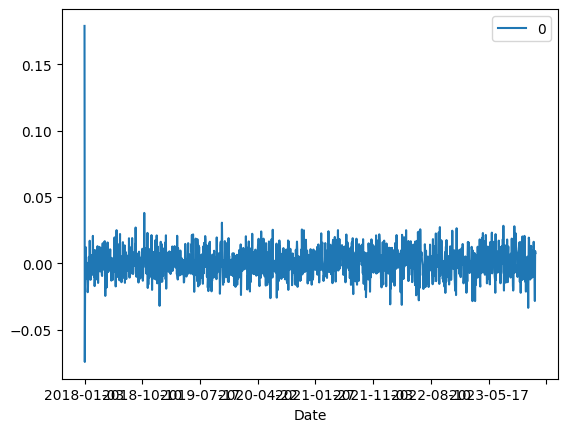

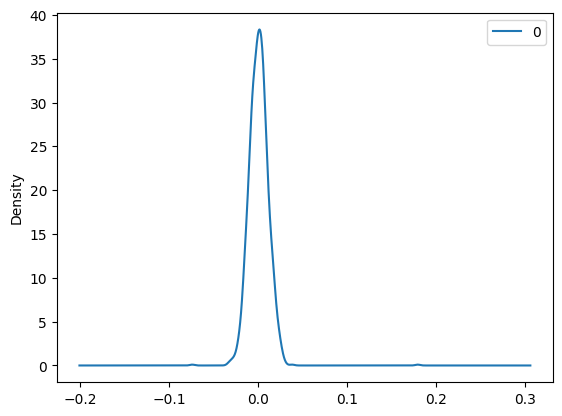

                 0
count  1563.000000
mean      0.000377
std       0.011328
min      -0.074402
25%      -0.006778
50%       0.000309
75%       0.006763
max       0.178980


In [11]:


model = ARIMA(data['Close'], order=(0,2,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [12]:
from sklearn.metrics import mean_squared_error
from math import sqrt

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


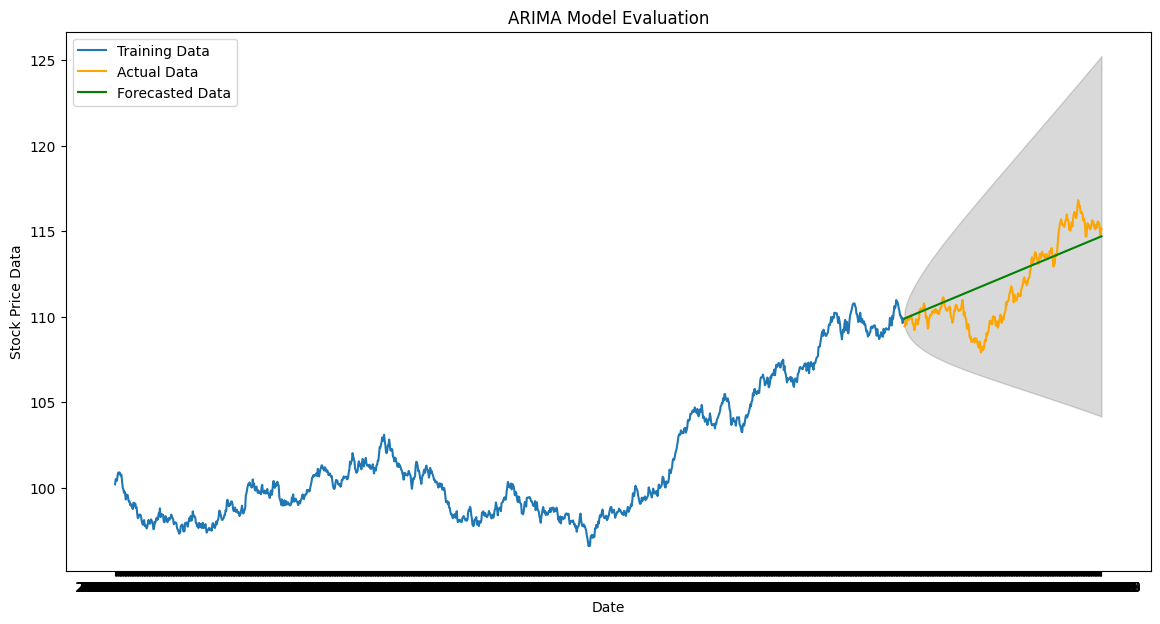

RMSE: 1.5293972290401119


In [13]:
data = pd.read_csv('Datasets/realistic_stock_prices.csv')
data.set_index('Date', inplace=True)
# Moving Averages (5-day, 20-day)
data['SMA_5'] = data['Close'].rolling(window=5, min_periods=1).mean()
data['SMA_20'] = data['Close'].rolling(window=20, min_periods=1).mean()

# # Daily Returns
# data['Daily_Returns'] = data['Close'].pct_change()



data['RSI'] = compute_rsi(data)
data.dropna(inplace=True)

X = data['Close'].values
# Split the data into train and test
train_size = int(len(data['Close']) * 0.8)
train, test = data['Close'][0:train_size], data['Close'][train_size:len(data['Close'])]

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train, order=(0, 2, 1))
model_train_fit = model_train.fit()

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

# Calculate the mean squared error
mse = mean_squared_error(test, test_forecast_series)
rmse = mse**0.5

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Stock Price Data')
plt.legend()
plt.show()

print('RMSE:', rmse)